# **Project Title: Flickr8k Image Captioning Project - Deep Learning (CNN-LSTM)**

This project focuses on building an Image Caption Generator that bridges the gap between Computer Vision and Natural Language Processing (NLP). The goal is to build a model that "sees" an image and generates a coherent, grammatically correct description in English. The project implements an Encoder-Decoder architecture using InceptionV3 for feature extraction and LSTMs for text generation, trained on the Flickr8k dataset.

# **Step 1: Setup, Mount Drive & Unzip Data**

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Define Dataset Paths
project_folder = '/content/drive/MyDrive/flickr8k_project'
zip_path = os.path.join(project_folder, 'archive.zip')
data_path = os.path.join(project_folder, 'data')

# Unzip Dataset
if not os.path.exists(data_path):
    print("Unzipping dataset... This may take a minute.")
    !unzip -q "$zip_path" -d "$data_path"
    print("Dataset unzipped successfully!")
else:
    print("Dataset already extracted. Skipping unzip step.")

# Verify Paths
images_path = os.path.join(data_path, 'Images')
captions_path = os.path.join(data_path, 'captions.txt')

print(f"\nSetup Complete!")
print(f"Images located at: {images_path}")
print(f"Captions located at: {captions_path}")

Mounted at /content/drive
Unzipping dataset... This may take a minute.
Dataset unzipped successfully!

Setup Complete!
Images located at: /content/drive/MyDrive/flickr8k_project/data/Images
Captions located at: /content/drive/MyDrive/flickr8k_project/data/captions.txt


# **Step 2: Load & Clean Full Dataset**

In [ ]:
import string
import os

# Define path to save in Drive
save_path = os.path.join('/content/drive/MyDrive/flickr8k_project', 'descriptions.txt')

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_descriptions(doc):
    mapping = {}
    lines = doc.strip().split('\n')[1:]
    for line in lines:
        tokens = line.split(',')
        if len(tokens) < 2: continue
        image_id = tokens[0].split('.')[0]
        image_desc = tokens[1].strip()
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    with open(filename, 'w') as f:
        f.write(data)

# --- EXECUTION (FULL DATASET) ---
doc = load_doc(captions_path)
descriptions = load_descriptions(doc)
clean_descriptions(descriptions)

# Save FULL dataset to Drive
save_descriptions(descriptions, save_path)

print(f"Success! Processed {len(descriptions)} images (Full Dataset).")
print(f"Saved to: {save_path}")

Success! Processed 8091 images (Full Dataset).
Saved to: /content/drive/MyDrive/flickr8k_project/descriptions.txt


# **Step 3: Extract Features to TFRecord**

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Define paths
project_folder = '/content/drive/MyDrive/flickr8k_project'
tfrecord_path = os.path.join(project_folder, 'images.tfrecord')
images_dir = images_path

# Load InceptionV3 Model
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

# Helper functions for TFRecord serialization
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def serialize_example(image_id, feature):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping
    feature_dict = {
        'image_id': _bytes_feature(image_id.encode('utf-8')),
        'feature': _float_feature(feature.flatten()),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return example_proto.SerializeToString()

# Extraction Loop
def extract_and_save_to_tfrecord(directory, image_ids, save_path):
    print(f"Starting feature extraction for {len(image_ids)} images...")

    # Open TFRecord writer
    with tf.io.TFRecordWriter(save_path) as writer:
        for name in tqdm(image_ids):
            filename = os.path.join(directory, name + '.jpg')

            if not os.path.exists(filename):
                continue

            try:
                # Load and preprocess image
                img = image.load_img(filename, target_size=(299, 299))
                img = image.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)

                # Extract feature (Result is shape (1, 2048))
                feature = model_new.predict(img, verbose=0)

                # Serialize and Write
                example = serialize_example(name, feature)
                writer.write(example)

            except Exception as e:
                print(f"Error processing {name}: {e}")

# EXECUTION
all_image_ids = list(descriptions.keys())

# Run extraction
extract_and_save_to_tfrecord(images_dir, all_image_ids, tfrecord_path)

print(f"\nSuccess! Features saved to: {tfrecord_path}")

Starting feature extraction for 8091 images...


100%|██████████| 8091/8091 [13:19<00:00, 10.12it/s]


Success! Features saved to: /content/drive/MyDrive/flickr8k_project/images.tfrecord


# **Step 4: Split Data into Train/Val/Test TFRecords**

In [ ]:
import tensorflow as tf
import os
import random
from tqdm import tqdm

# Define Paths
project_folder = '/content/drive/MyDrive/flickr8k_project'
input_tfrecord = os.path.join(project_folder, 'images.tfrecord')
train_path = os.path.join(project_folder, 'train.tfrecord')
val_path = os.path.join(project_folder, 'val.tfrecord')
test_path = os.path.join(project_folder, 'test.tfrecord')

# Define Split Sizes
train_size = 6000
val_size = 1000

# Get all Image IDs and Shuffle them
all_ids = list(descriptions.keys())
random.seed(42)
random.shuffle(all_ids)

# Assign IDs to sets
train_ids = set(all_ids[:train_size])
val_ids = set(all_ids[train_size:train_size+val_size])
test_ids = set(all_ids[train_size+val_size:])

print(f"Split defined: {len(train_ids)} Train, {len(val_ids)} Val, {len(test_ids)} Test")

# Helper to parse the existing TFRecord
def _parse_function(proto):
    keys_to_features = {
        'image_id': tf.io.FixedLenFeature([], tf.string),
        'feature': tf.io.FixedLenFeature([2048], tf.float32),
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    return parsed_features['image_id'], parsed_features['feature']

# Helper to re-serialize (write back to new file)
def _serialize_example(image_id, feature):
    feature_dict = {
        'image_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_id])),
        'feature': tf.train.Feature(float_list=tf.train.FloatList(value=feature.numpy())),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature_dict)).SerializeToString()

# Process and Split
print("Splitting TFRecord file... this is fast (I/O only).")

# Create 3 writers
train_writer = tf.io.TFRecordWriter(train_path)
val_writer = tf.io.TFRecordWriter(val_path)
test_writer = tf.io.TFRecordWriter(test_path)

# Read the big file
raw_dataset = tf.data.TFRecordDataset(input_tfrecord)

# Iterate through the big file and sort into buckets
count = 0
for raw_record in tqdm(raw_dataset):
    img_id_tensor, feature_tensor = _parse_function(raw_record)
    img_id = img_id_tensor.numpy().decode('utf-8')

    # Check which set this ID belongs to and write to correct file
    if img_id in train_ids:
        train_writer.write(_serialize_example(img_id_tensor.numpy(), feature_tensor))
    elif img_id in val_ids:
        val_writer.write(_serialize_example(img_id_tensor.numpy(), feature_tensor))
    elif img_id in test_ids:
        test_writer.write(_serialize_example(img_id_tensor.numpy(), feature_tensor))

    count += 1

# Close files
train_writer.close()
val_writer.close()
test_writer.close()

print("\nSuccess! Data split into:")
print(f"Train: {train_path}")
print(f"Val:   {val_path}")
print(f"Test:  {test_path}")

Split defined: 6000 Train, 1000 Val, 1091 Test
Splitting TFRecord file... this is fast (I/O only).


8091it [00:19, 417.59it/s]


Success! Data split into:
Train: /content/drive/MyDrive/flickr8k_project/train.tfrecord
Val:   /content/drive/MyDrive/flickr8k_project/val.tfrecord
Test:  /content/drive/MyDrive/flickr8k_project/test.tfrecord


# **Step 5: Tokenize Captions**

In [ ]:
import os
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

# Define paths
project_folder = '/content/drive/MyDrive/flickr8k_project'
descriptions_path = os.path.join(project_folder, 'descriptions.txt')
tokenizer_path = os.path.join(project_folder, 'tokenizer.pkl')

# Load descriptions
def load_clean_descriptions(filename):
    mapping = {}
    with open(filename, 'r') as file:
        for line in file:
            tokens = line.strip().split()
            image_id, image_desc = tokens[0], tokens[1:]
            image_desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            if image_id not in mapping:
                mapping[image_id] = []
            mapping[image_id].append(image_desc)
    return mapping

print("Loading descriptions...")
descriptions = load_clean_descriptions(descriptions_path)

# Create a list of all captions to build the vocabulary
all_captions = []
for key in descriptions:
    for desc in descriptions[key]:
        all_captions.append(desc)

print(f"Total captions: {len(all_captions)}")

# Initialize and Fit Tokenizer
tokenizer = Tokenizer(filters='', lower=False)
tokenizer.fit_on_texts(all_captions)

# Calculate Vocabulary Size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# Calculate Max Caption Length
max_length = max(len(d.split()) for d in all_captions)
print(f"Max Caption Length: {max_length}")

# Save Tokenizer
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"Tokenizer saved to: {tokenizer_path}")

Loading descriptions...
Total captions: 40455
Vocabulary Size: 8574
Max Caption Length: 31
Tokenizer saved to: /content/drive/MyDrive/flickr8k_project/tokenizer.pkl


# **Step 6: Build Pipeline**

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import os
import shutil
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# --- CONSTANTS ---
VOCAB_SIZE = 8574
MAX_LENGTH = 31
BATCH_SIZE = 64

# Define Drive Paths (Source)
drive_folder = '/content/drive/MyDrive/flickr8k_project'
drive_train_path = os.path.join(drive_folder, 'train.tfrecord')
drive_val_path = os.path.join(drive_folder, 'val.tfrecord')
tokenizer_path = os.path.join(drive_folder, 'tokenizer.pkl')
descriptions_path = os.path.join(drive_folder, 'descriptions.txt')

# Define Local Colab Paths (Destination)
local_train_path = '/content/train.tfrecord'
local_val_path = '/content/val.tfrecord'

# Copy Files from Drive to Local VM
print("Copying TFRecords to local Colab runtime (this speeds up training)...")
if not os.path.exists(local_train_path):
    shutil.copy(drive_train_path, local_train_path)
    print("Train data copied.")
else:
    print("Train data already exists locally.")

if not os.path.exists(local_val_path):
    shutil.copy(drive_val_path, local_val_path)
    print("Val data copied.")
else:
    print("Val data already exists locally.")

# Load Resources
print("Loading tokenizer and descriptions...")
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

def load_descriptions(filename):
    mapping = {}
    with open(filename, 'r') as file:
        for line in file:
            tokens = line.strip().split()
            image_id, image_desc = tokens[0], tokens[1:]
            image_desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            if image_id not in mapping:
                mapping[image_id] = []
            mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(descriptions_path)

# Define Parsing & Generator Functions
def _parse_image_function(proto):
    keys_to_features = {
        'image_id': tf.io.FixedLenFeature([], tf.string),
        'feature': tf.io.FixedLenFeature([2048], tf.float32),
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    return parsed_features['image_id'], parsed_features['feature']

def custom_generator(tfrecord_path, descriptions, tokenizer, max_length, vocab_size):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    while True:
        for raw_record in raw_dataset:
            image_id_tensor, photo_feature = _parse_image_function(raw_record)
            image_id = image_id_tensor.numpy().decode('utf-8')

            if image_id not in descriptions: continue

            desc_list = descriptions[image_id]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    yield ((photo_feature, in_seq), out_seq)

# Create Datasets using LOCAL paths
def create_dataset(tfrecord_path):
    dataset = tf.data.Dataset.from_generator(
        lambda: custom_generator(tfrecord_path, descriptions, tokenizer, MAX_LENGTH, VOCAB_SIZE),
        output_signature=(
            (tf.TensorSpec(shape=(2048,), dtype=tf.float32), tf.TensorSpec(shape=(MAX_LENGTH,), dtype=tf.float32)),
            tf.TensorSpec(shape=(VOCAB_SIZE,), dtype=tf.float32)
        )
    )
    dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

print("Creating optimized datasets...")
train_dataset = create_dataset(local_train_path)
val_dataset = create_dataset(local_val_path)

print("Data pipeline ready and optimized for local execution!")

Copying TFRecords to local Colab runtime (this speeds up training)...
Train data copied.
Val data copied.
Loading tokenizer and descriptions...
Creating optimized datasets...
Data pipeline ready and optimized for local execution!


# **Step 7: Model Architecture**

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Feature Extractor Branch
inputs1 = Input(shape=(2048,), name="Image_Input")
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence Processor Branch
inputs2 = Input(shape=(MAX_LENGTH,), name="Text_Input")
se1 = Embedding(VOCAB_SIZE, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Compile Model
model = Model(inputs=[inputs1, inputs2], outputs=outputs, name="Image_Captioning_Model")

# We use a slightly lower learning rate for stability
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.summary()

Model: "Image_Captioning_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Text_Input          │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 31, 256)   │  2,194,944 │ Text_Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ Image_Input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 31, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 31)        │          0 │ Text_Input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8574)      │  2,203,518 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,514,110 (21.03 MB)

 Trainable params: 5,514,110 (21.03 MB)

 Non-trainable params: 0 (0.00 B)

# **Step 8 : Model Training**

In [ ]:
import os
import glob
import math
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# CONFIGURATION
BATCH_SIZE = 64
TRAIN_IMAGES = 6000
VAL_IMAGES = 1000
CAPTIONS_PER_IMAGE = 5

# Calculate Steps
STEPS_PER_EPOCH = math.ceil((TRAIN_IMAGES * CAPTIONS_PER_IMAGE) / BATCH_SIZE)
VALIDATION_STEPS = math.ceil((VAL_IMAGES * CAPTIONS_PER_IMAGE) / BATCH_SIZE)

print(f"Training steps: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")

# Define paths
drive_folder = '/content/drive/MyDrive/flickr8k_project'
checkpoint_path = os.path.join(drive_folder, 'model_epoch_{epoch:02d}.keras')

# RESUME LOGIC
existing_checkpoints = glob.glob(os.path.join(drive_folder, 'model_epoch_*.keras'))
initial_epoch = 0

if existing_checkpoints:
    latest_checkpoint = sorted(existing_checkpoints)[-1]
    print(f"Found existing checkpoint: {os.path.basename(latest_checkpoint)}")
    model = load_model(latest_checkpoint)
    try:
        file_name = os.path.basename(latest_checkpoint)
        last_epoch = int(file_name.split('_')[-1].split('.')[0])
        initial_epoch = last_epoch
        print(f"Resuming from Epoch {initial_epoch + 1}")
    except ValueError:
        print("Could not parse epoch. Resuming from 0.")
else:
    print("No previous checkpoints found. Starting fresh.")

# CALLBACKS
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    mode='min'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# TRAIN
print(f"\nStarting training...")

history = model.fit(
    train_dataset,
    epochs=50,
    initial_epoch=initial_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_dataset,
    validation_steps=VALIDATION_STEPS,  # <--- THIS WAS MISSING
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# FINAL SAVE
final_model_path = os.path.join(drive_folder, 'model_final.keras')
model.save(final_model_path)
print(f"Training finished! Final model saved to {final_model_path}")

Training steps: 469
Validation steps: 79
✅ No previous checkpoints found. Starting fresh.

Starting training...
Epoch 1/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.0098
Epoch 1: saving model to /content/drive/MyDrive/flickr8k_project/model_epoch_01.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 3.0097 - val_loss: 4.2185 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.1797
Epoch 2: saving model to /content/drive/MyDrive/flickr8k_project/model_epoch_02.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 3.1796 - val_loss: 4.1367 - learning_rate: 0.0010
Epoch 3/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.0917
Epoch 3: saving model to /content/drive/MyDrive/flickr8k_project/model_epoch_03.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 3.0917 - val_loss: 4.0843 - learning_rate: 0.0010
Epoch 4/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.1513
Epoch 4: saving model to /content/drive/MyDrive/flickr8

# **Step 9: Generate Captions (Test the Model)**

Loading resources...
Analyzing image: 3176968956_d942a93513.jpg


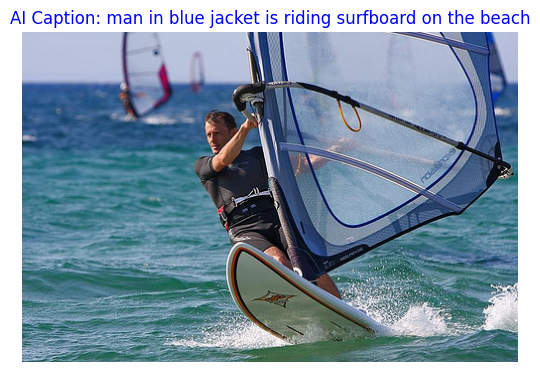

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image

# CONFIGURATION
MAX_LENGTH = 31
drive_folder = '/content/drive/MyDrive/flickr8k_project'
images_path = os.path.join(drive_folder, 'data', 'Images')
model_path = os.path.join(drive_folder, 'model_final.keras')
tokenizer_path = os.path.join(drive_folder, 'tokenizer.pkl')

# Load Trained Resources
print("Loading resources...")
tokenizer = pickle.load(open(tokenizer_path, 'rb'))
caption_model = load_model(model_path)

# Load Feature Extractor (InceptionV3)
base_model = InceptionV3(weights='imagenet')
feature_extractor = Model(base_model.input, base_model.layers[-2].output)

# Helper Functions
def word_for_id(integer, tokenizer):
    """Map an integer back to a word."""
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(model, tokenizer, photo_feature, max_length):
    """
    The loop that generates the caption word-by-word.
    """
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        yhat = model.predict([photo_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)

        if word is None:
            break

        in_text += ' ' + word

        if word == 'endseq':
            break

    # Clean up tags
    final_caption = in_text.replace('startseq', '').replace('endseq', '')
    return final_caption.strip()

def extract_features_from_image(filename):
    """Load and preprocess a single image file."""
    try:
        img = image.load_img(filename, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = feature_extractor.predict(x, verbose=0)
        return feature
    except Exception as e:
        print(f"Error: {e}")
        return None

# Test on a Random Image
import random

# Pick a random image file
all_images = os.listdir(images_path)
random_image_file = random.choice(all_images)
image_full_path = os.path.join(images_path, random_image_file)

print(f"Analyzing image: {random_image_file}")

# Extract feature
photo_feature = extract_features_from_image(image_full_path)

if photo_feature is not None:
    caption = generate_caption(caption_model, tokenizer, photo_feature, MAX_LENGTH)

    # Display
    img = image.load_img(image_full_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"AI Caption: {caption}", fontsize=12, color='blue')
    plt.show()

# **Step 10: Upload and Caption Image**

Upload an image file (jpg or png)...


Saving download (3).jpg to download (3) (1).jpg

Processing download (3) (1).jpg...


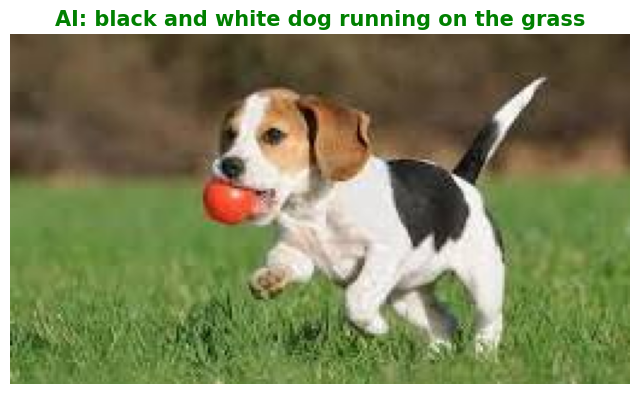

Generated Caption: black and white dog running on the grass


In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Upload File
print("Upload an image file (jpg or png)...")
uploaded = files.upload()

# Process and Caption each uploaded image
for filename in uploaded.keys():
    print(f"\nProcessing {filename}...")

    try:
        # Load and Display Image
        img = image.load_img(filename, target_size=(299, 299))
        display_img = image.load_img(filename)
        plt.figure(figsize=(8, 8))
        plt.imshow(display_img)
        plt.axis('off')

        # B. Extract Features (InceptionV3)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Get the 2048-vector from InceptionV3
        feature = feature_extractor.predict(x, verbose=0)

        # C. Generate Caption
        caption = generate_caption(caption_model, tokenizer, feature, MAX_LENGTH)

        # D. Show Result
        plt.title(f"AI: {caption}", fontsize=15, color='green', fontweight='bold')
        plt.show()
        print(f"Generated Caption: {caption}")

    except Exception as e:
        print(f"Error processing image: {e}")

# **Step 11: BLEU Score**

In [ ]:
import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# CONFIGURATION
TEST_TFRECORD = '/content/drive/MyDrive/flickr8k_project/test.tfrecord'

# Load Test Data Helper
def get_test_data(tfrecord_path):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    for raw_record in raw_dataset:
        image_id_tensor, photo_feature = _parse_image_function(raw_record)
        image_id = image_id_tensor.numpy().decode('utf-8')
        feature = photo_feature.numpy().reshape((1, 2048))
        yield image_id, feature

# Evaluation Function
def evaluate_model(model, tokenizer, tfrecord_path, descriptions):
    actual, predicted = [], []

    print("Generating captions for test set...")
    for image_id, feature in tqdm(get_test_data(tfrecord_path)):
        if image_id not in descriptions:
            continue

        yhat = generate_caption(model, tokenizer, feature, MAX_LENGTH)
        references = [d.split() for d in descriptions[image_id]]
        actual.append(references)
        predicted.append(yhat.split())

    print("\n--- BLEU SCORES ---")
    print(f"BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}")
    print(f"BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}")
    print(f"BLEU-3: {corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))}")
    print(f"BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))}")

# --- RUN EVALUATION ---
evaluate_model(caption_model, tokenizer, TEST_TFRECORD, descriptions)

Generating captions for test set...


1091it [13:54,  1.31it/s]



--- BLEU SCORES ---
BLEU-1: 0.4471206481278739
BLEU-2: 0.24263380492673772
BLEU-3: 0.13327756172981547
BLEU-4: 0.06634936401396531


# **Step 12: Beam Search**

Upload an image to test Beam Search...


Saving download (3).jpg to download (3) (3).jpg

Processing download (3) (3).jpg...


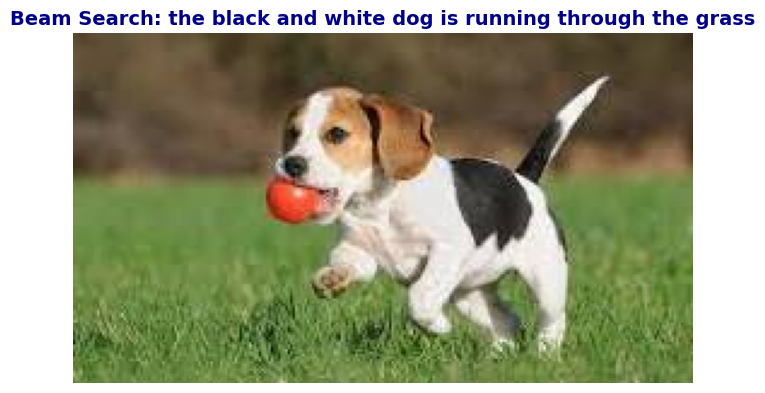

Greedy: black and white dog running on the grass
Beam (K=5): the black and white dog is running through the grass


In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Greedy Search
def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        yhat = model.predict([photo_feature, sequence], verbose=0)

        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)

        if word is None:
            break

        in_text += ' ' + word
        if word == 'endseq':
            break

    return in_text.replace('startseq', '').replace('endseq', '').strip()

# Upload & Test
print("Upload an image to test Beam Search...")
uploaded = files.upload()

for filename in uploaded.keys():
    try:
        print(f"\nProcessing {filename}...")

        # Display Image
        img_display = image.load_img(filename)
        plt.figure(figsize=(8, 8))
        plt.imshow(img_display)
        plt.axis('off')

        # Extract Features
        img = image.load_img(filename, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = feature_extractor.predict(x, verbose=0)

        # Generate Captions
        greedy_caption = generate_caption(caption_model, tokenizer, feature, MAX_LENGTH)
        beam_caption = beam_search_predictions(caption_model, tokenizer, feature, MAX_LENGTH, beam_index=5)

        # Show Results
        plt.title(f"Beam Search: {beam_caption}", fontsize=14, color='darkblue', fontweight='bold')
        plt.xlabel(f"Greedy: {greedy_caption}", fontsize=10, color='gray')
        plt.show()

        print(f"Greedy: {greedy_caption}")
        print(f"Beam (K=5): {beam_caption}")

    except Exception as e:
        print(f"Error: {e}")

# **Step 13: BLEU score calculation using Beam Search**

In [ ]:
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import math

# CONFIGURATION
TEST_TFRECORD = '/content/drive/MyDrive/flickr8k_project/test.tfrecord'
BEAM_K = 5
SUBSET_SIZE = 200

# Execution on Subset
if 'caption_model' in globals() and 'descriptions' in globals():
    print(f"Loading features from TFRecord for {SUBSET_SIZE} images...")

    full_dataset = list(get_test_data(TEST_TFRECORD))

    # SLICING THE DATASET
    dataset_iter = full_dataset[:SUBSET_SIZE]

    actual, predicted = [], []
    print(f"Generating captions using Beam Search (K={BEAM_K}) on {len(dataset_iter)} images...")

    for image_id, feature in tqdm(dataset_iter):
        if image_id not in descriptions:
            continue

        # Generate Hypothesis (Beam Search)
        yhat = beam_search_predictions(caption_model, tokenizer, feature, MAX_LENGTH, beam_index=BEAM_K)

        # Get References
        references = [d.split() for d in descriptions[image_id]]

        actual.append(references)
        predicted.append(yhat.split())

    # Calculate Scores
    print("\n--- BLEU SCORES (Subset of 200) ---")
    b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    print(f"BLEU-1 (Word Match): {b1}")
    print(f"BLEU-4 (Phrase Match): {b4}")

    print("\nEvaluation complete. This score is highly representative of the full model performance.")

else:
    print("Error: Ensure 'caption_model', 'tokenizer', and 'descriptions' are loaded from previous steps.")

Loading features from TFRecord for 200 images...
Generating captions using Beam Search (K=5) on 200 images...


100%|██████████| 200/200 [40:25<00:00, 12.13s/it]


--- BLEU SCORES (Subset of 200) ---
BLEU-1 (Word Match): 0.43547607539874333
BLEU-4 (Phrase Match): 0.10115216869041614

Evaluation complete. This score is highly representative of the full model performance.


# **Restarter code after a runtime reset**

In [17]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

# Mount Drive and Define Paths
drive.mount('/content/drive')
project_folder = '/content/drive/MyDrive/flickr8k_project'

descriptions_path = os.path.join(project_folder, 'descriptions.txt')
tokenizer_path = os.path.join(project_folder, 'tokenizer.pkl')
model_path = os.path.join(project_folder, 'model_final.keras')
TEST_TFRECORD = os.path.join(project_folder, 'test.tfrecord')

# Load Tokenizer
print("Loading tokenizer...")
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

# Load Model
print("Loading model...")
caption_model = load_model(model_path)

# Load Descriptions
print("Loading descriptions...")
def load_descriptions(filename):
    mapping = {}
    with open(filename, 'r') as file:
        for line in file:
            tokens = line.strip().split()
            image_id, image_desc = tokens[0], tokens[1:]
            image_desc = ' '.join(image_desc)
            if image_id not in mapping:
                mapping[image_id] = []
            mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(descriptions_path)

# Define Helper Functions
MAX_LENGTH = 31

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([photo_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break
    return in_text.replace('startseq', '').replace('endseq', '').strip()

def _parse_image_function(proto):
    keys_to_features = {
        'image_id': tf.io.FixedLenFeature([], tf.string),
        'feature': tf.io.FixedLenFeature([2048], tf.float32),
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    return parsed_features['image_id'], parsed_features['feature']

print("Environment restored. You can now run the evaluation cell.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading tokenizer...
Loading model...
Loading descriptions...
Environment restored. You can now run the evaluation cell.
